In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

base_pth, code_pth, data_pth, rslt_pth, fig_pth = can.utils.setup_paths()
plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

# JG075C: MMMMx blocker tripartite competition (separate)

In [36]:
cmax = 50

JG075C = (
    QuantStudio(rslt_pth / 'JG075C MMMMx blocker tripartite competition separate.xlsx', 'JG075C')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore('FAM')
)

# Denote reaction conditions
JG075C.reactions.wide = (
    JG075C.reactions.wide
    .replace(
        {'Target': {
            'S075_WTFAM': 'S075_WT',
            'S075_WTHEX': 'S075_WT',
            'S075_SNVFAM': 'S075_SNV',
            'S075_SNVHEX': 'S075_SNV',
        }
        })
    .merge(pd.read_csv(base_pth / 'Experimental' / 'JG075C Plate Map.csv'))#[['Sample','WT Conc','Competitor Conc','Primer Conc']])
    .assign(lg10_Blocker = lambda df: np.log10(df['Blocker μM']))
    .replace({'lg10_Blocker': {-np.inf: -2}})
    .drop(columns=['CT'])
)


JG075C.reactions.neaten()
JG075C.extract_endpoints(cmax=cmax)
endpoints = JG075C.endpoints
JG075C.reactions

/home/johngoertz/miniconda3/envs/candas/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Sample,Task,Comments,Reaction,Blocker,Blocker μM,Configuration,WellName,lg10_Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075C,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075C_001,STANDARD,,0,MMMMx,3.162278,2+2,A1,0.5,1,0.000105,0.002424
1,JG075C,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075C_001,STANDARD,,0,MMMMx,3.162278,2+2,A1,0.5,2,-0.000678,0.002541
2,JG075C,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075C_001,STANDARD,,0,MMMMx,3.162278,2+2,A1,0.5,3,-0.000475,0.001946
3,JG075C,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075C_001,STANDARD,,0,MMMMx,3.162278,2+2,A1,0.5,4,0.001230,0.000267
4,JG075C,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075C_001,STANDARD,,0,MMMMx,3.162278,2+2,A1,0.5,5,0.000943,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,JG075C,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075C_376,STANDARD,,495,MMMMx,0.000000,7+2,P16,-2.0,86,1.640612,1.171841
44636,JG075C,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075C_376,STANDARD,,495,MMMMx,0.000000,7+2,P16,-2.0,87,1.692190,1.212729
44637,JG075C,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075C_376,STANDARD,,495,MMMMx,0.000000,7+2,P16,-2.0,88,1.721702,1.234851
44638,JG075C,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075C_376,STANDARD,,495,MMMMx,0.000000,7+2,P16,-2.0,89,1.742944,1.249939


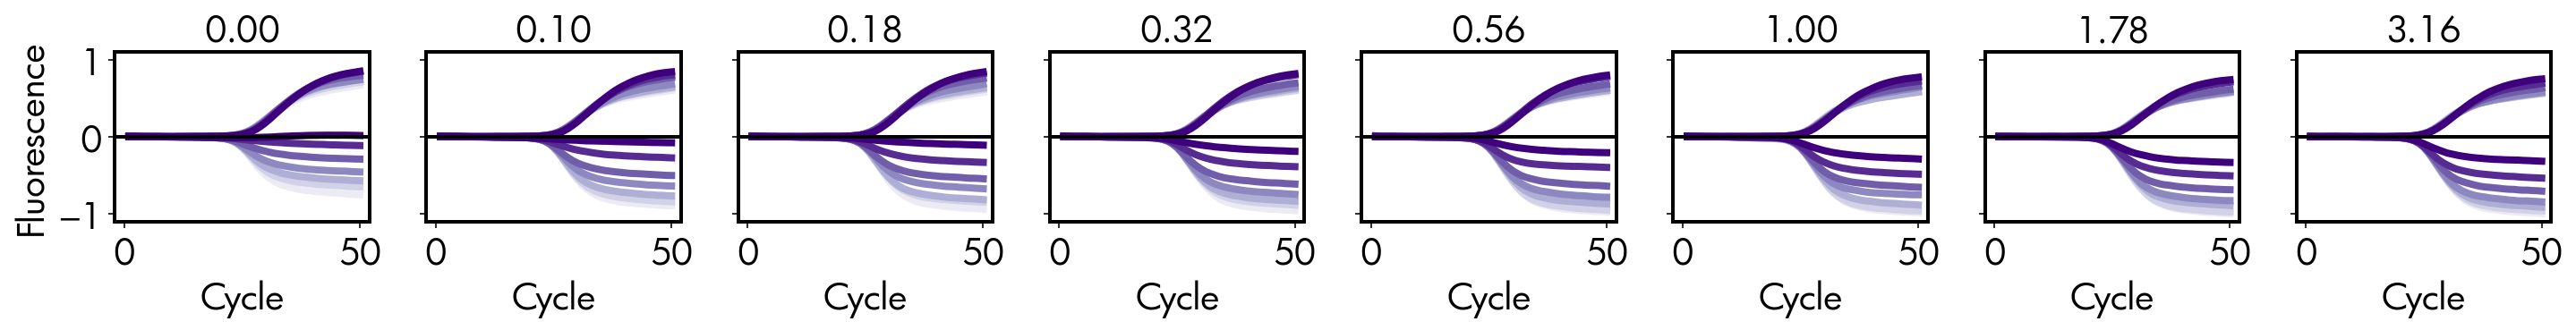

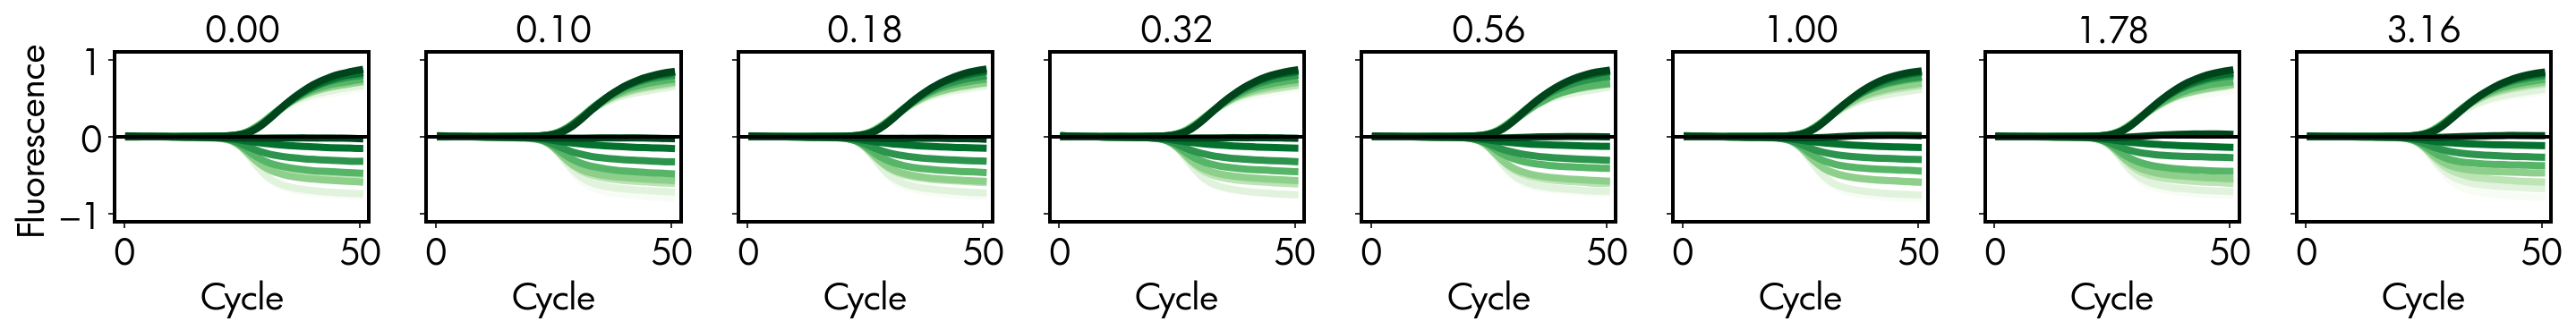

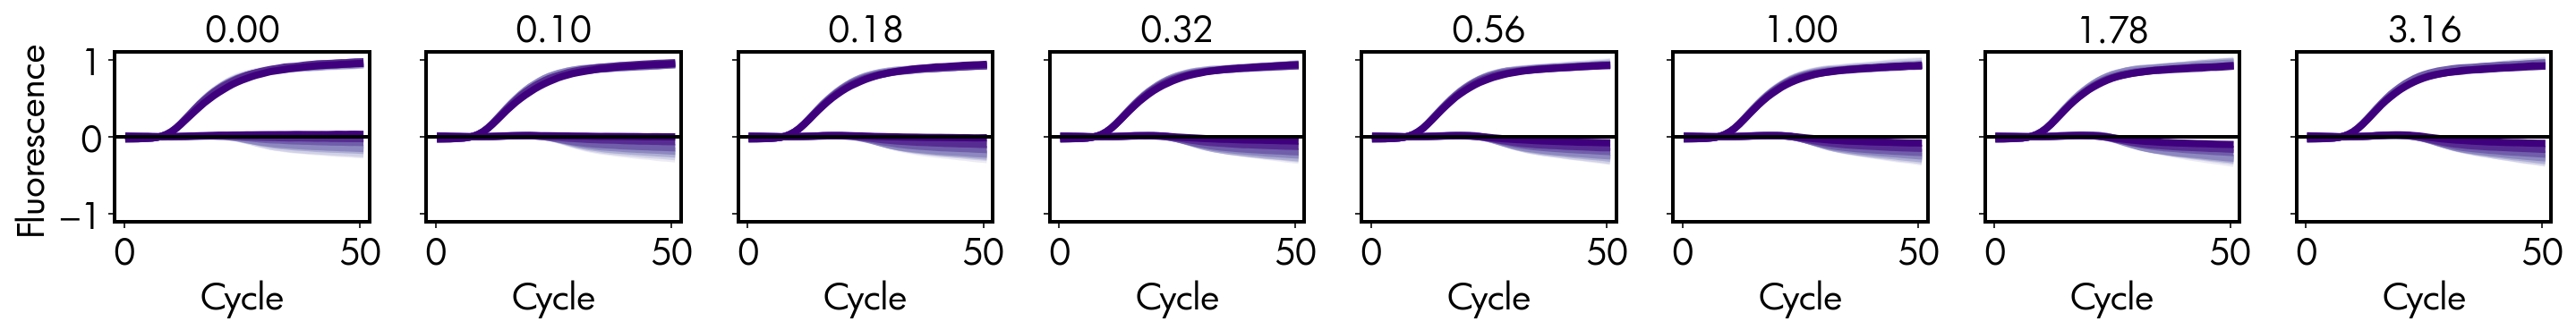

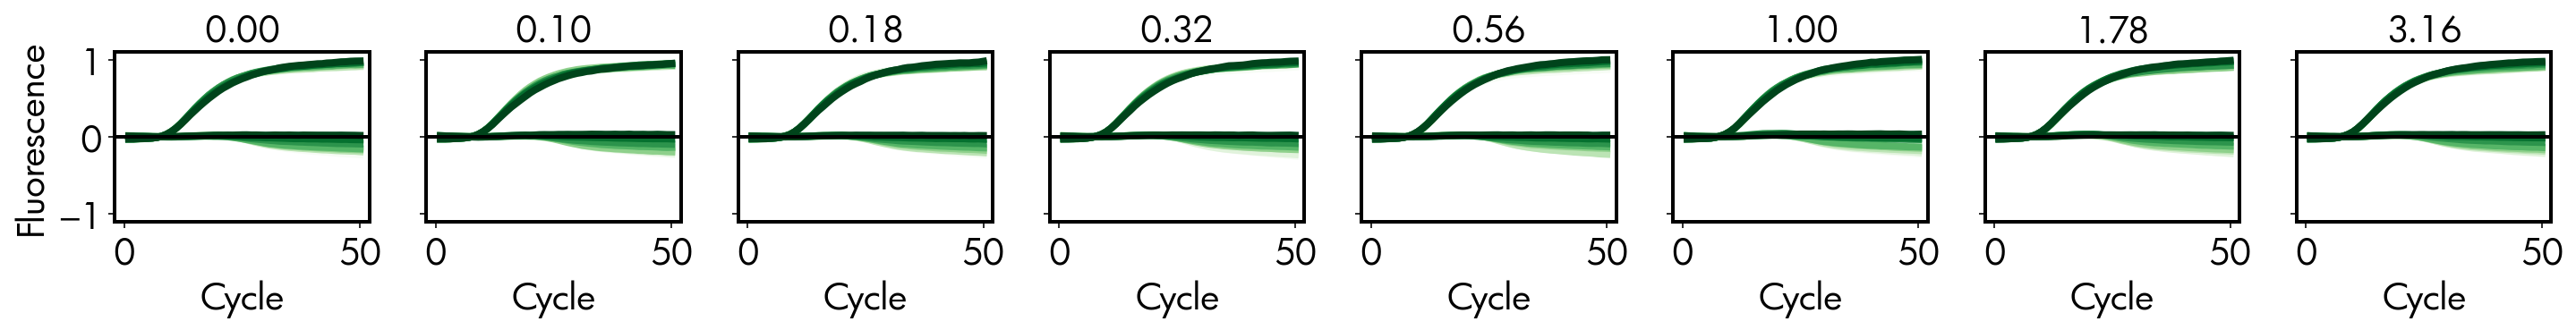

In [37]:
hue = 'lg10_Copies'
extent = np.max(np.abs(JG075C.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075C.reactions.wide[hue].min(), vmax=JG075C.reactions.wide[hue].max())

blocker = 'L-MMMMx'
configs = ['2+2','7+2']

for config in configs:
    for target, palette in target_palette:
        data = JG075C.reactions.data
        data = data[
            (data.Cycle<=cmax) &
            (data.Target==target) &
            (data.Configuration==config)
        ]

        g = sns.relplot(data = data,
                        x='Cycle', y='Fluorescence', col='Blocker μM', units='Reaction', hue = hue,
                        legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None, 
                        height=3, aspect=0.85, linewidth=4,
                        facet_kws={
                            'margin_titles': True,
                            'despine': False})

        g.refline(y=0, color='k', linestyle='-')
        g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
        g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
        # g.set_titles(col_template="", row_template="")
        plt.tight_layout();

        # can.utils.savefig('JG075A GBP6 Tripartite Curves')

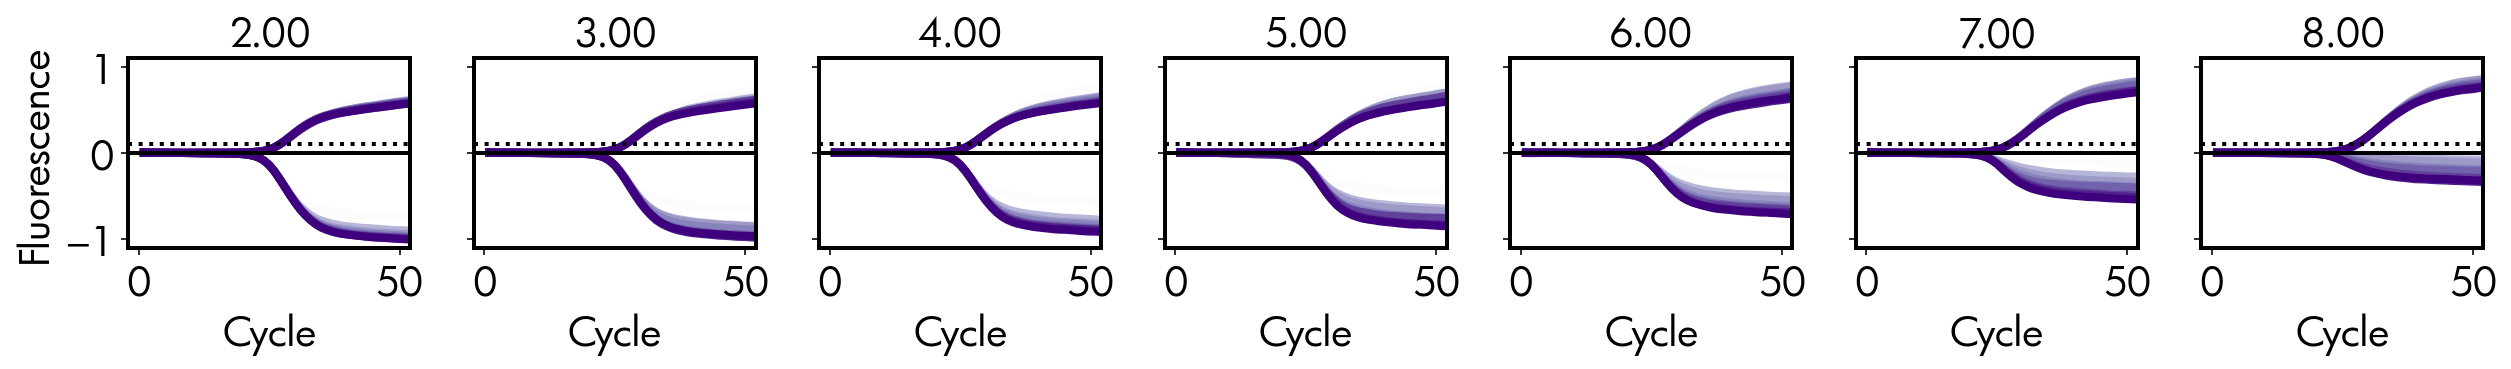

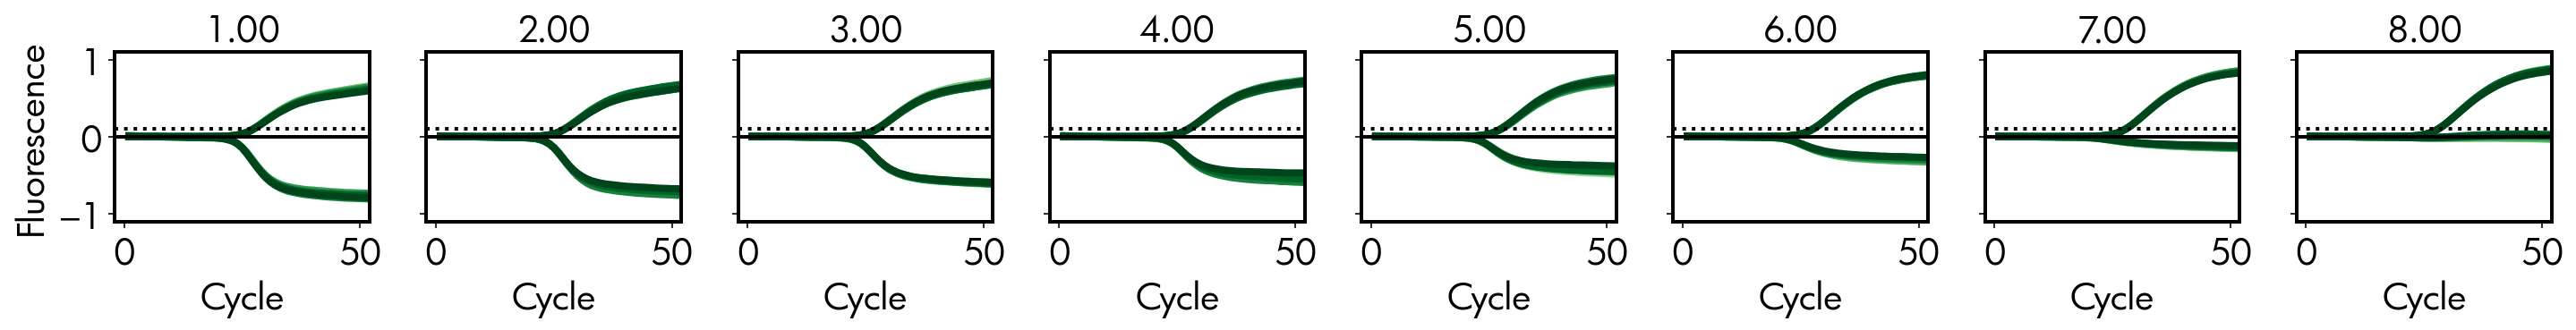

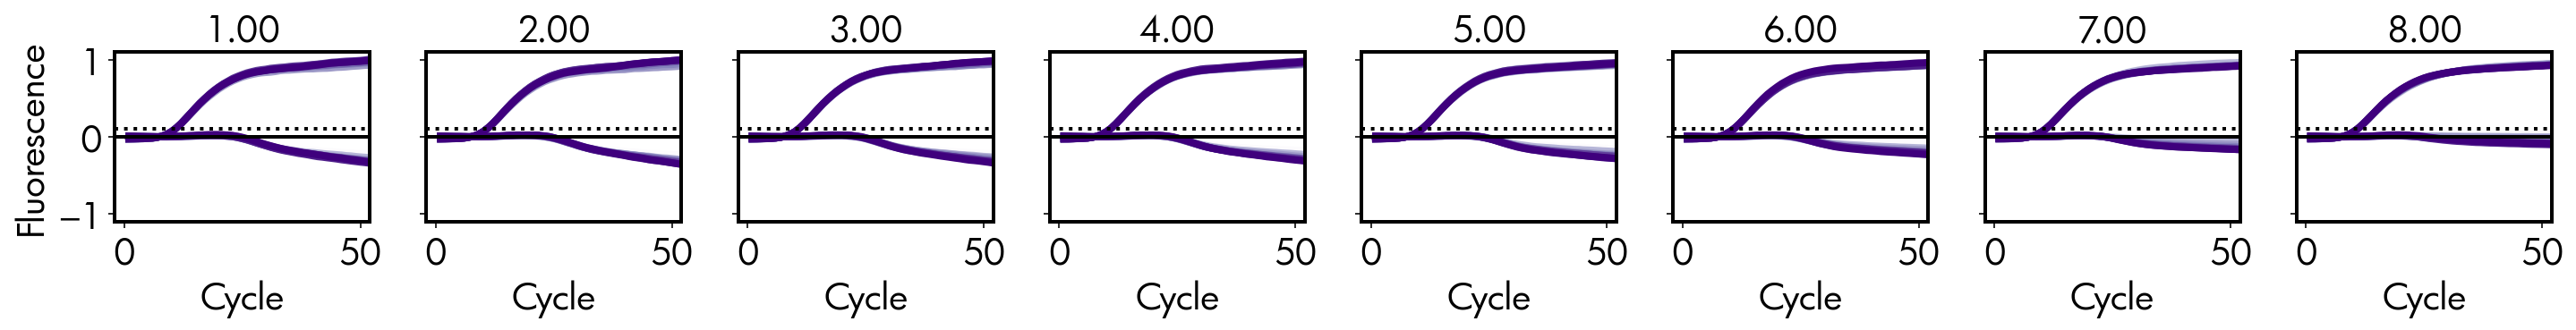

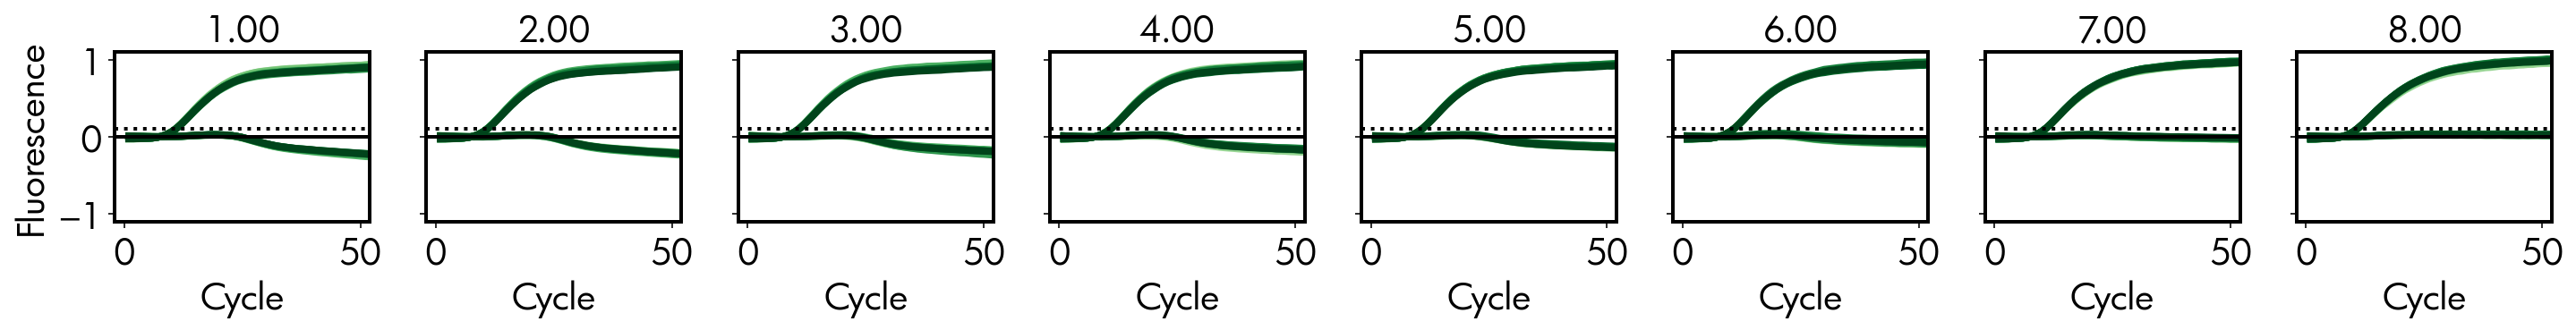

In [38]:
hue = 'lg10_Blocker'
extent = np.max(np.abs(JG075C.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075C.reactions.wide[hue].min(), vmax=JG075C.reactions.wide[hue].max())


for config in configs:
    for target, palette in target_palette:
        data = JG075C.reactions.data
        data = data[
            (data.Configuration==config) &
            (data.Target==target)
        ]

        g = sns.relplot(data = data,
                        x='Cycle', y='Fluorescence', col='lg10_Copies', units='Reaction', hue = hue,
                        legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None,
                        height=3, aspect=0.85, linewidth=4,
                        row_order = JG075C.reactions.data['lg10_Copies'].unique()[::-1],
                        facet_kws={
                            'margin_titles': True,
                            'despine': False})

        g.refline(y=0, color='k', linestyle='-')
        g.refline(y=0.1, color='k', linestyle=':')
        g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
        g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
        # g.set_titles(col_template="", row_template="")
        plt.tight_layout();

    # can.utils.savefig('JG075A GBP6 Tripartite Curves')

In [39]:
ds = gmb.DataSet(JG075C.endpoints, outputs=['SignalDifference'])
gp = gmb.GP(ds).fit(continuous_dims = ['lg10_Copies', 'Blocker μM'],
                    categorical_dims=['Configuration', 'Target'])

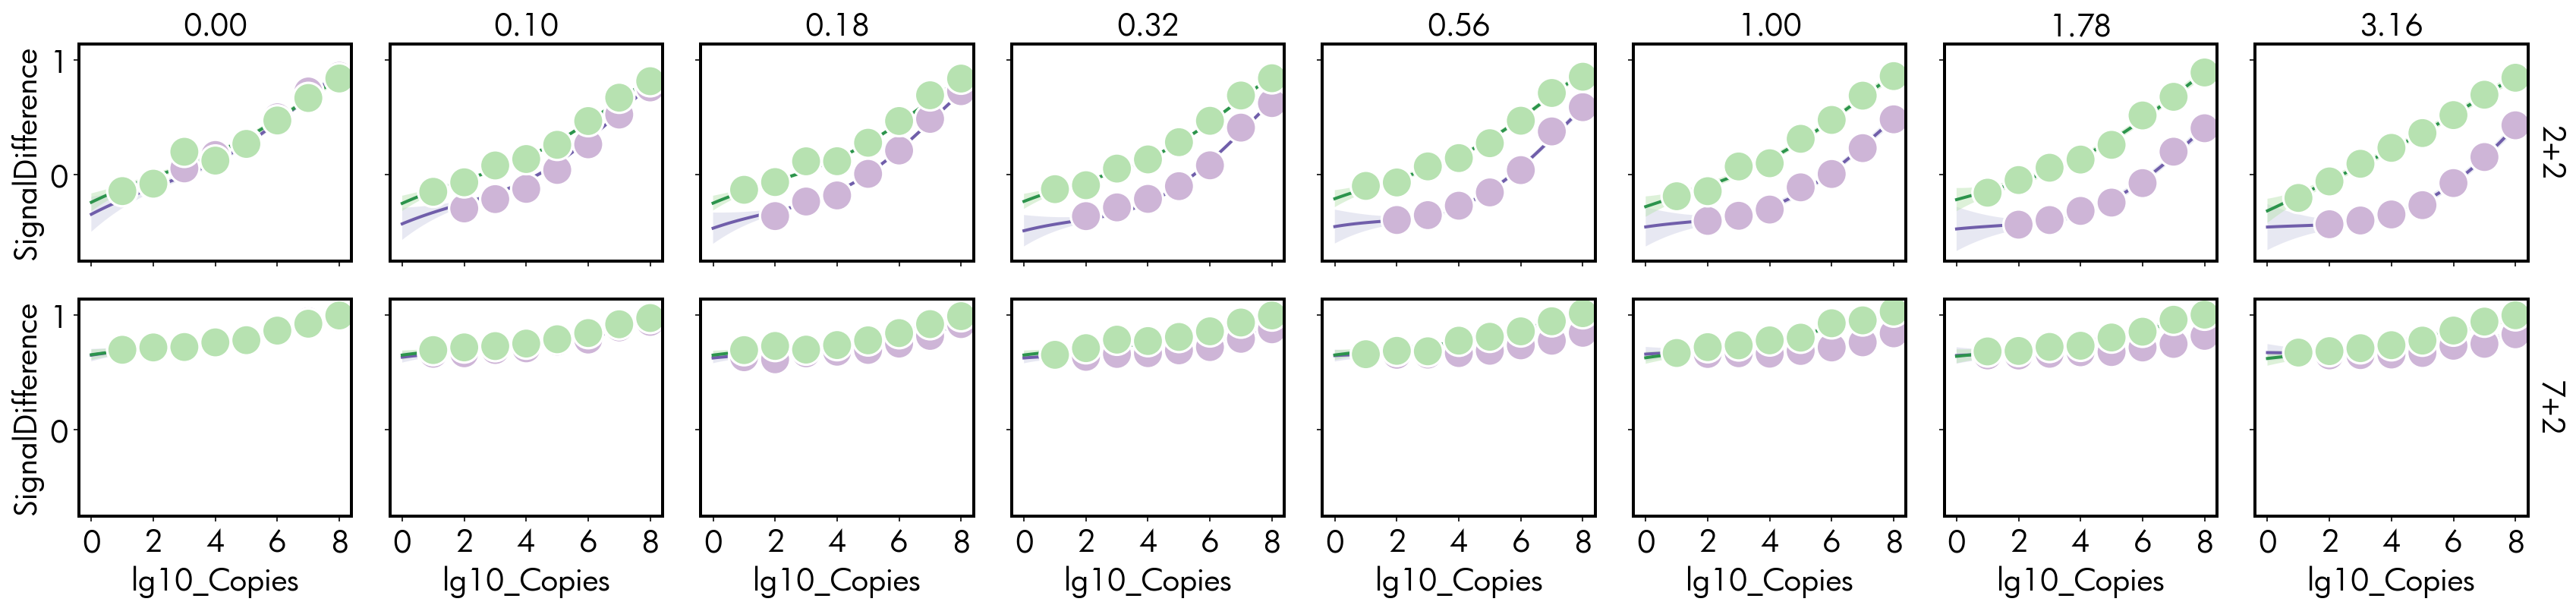

In [40]:
hue = 'SignalDifference'
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)

g = sns.relplot(data = endpoints,
                x='lg10_Copies', y='SignalDifference', 
                col='Blocker μM', row='Configuration',
                hue = 'Target', legend = False, palette='PRGn',
                kind='scatter', height=3, aspect=1.0, s=20**2,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for (row_val, col_val), ax in g.axes_dict.items():
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(lg10_Copies=[0,8])
    X = gp.prepare_grid(at=at, limits=limits)['lg10_Copies']
    WT_sig = gp.predict_grid(categorical_levels={'Target': 'S075_WT', 'Configuration': row_val}, with_noise=False)
    SNV_sig = gp.predict_grid(categorical_levels={'Target': 'S075_SNV', 'Configuration': row_val}, with_noise=False)
    
    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=WT_sig).plot(palette='Purples')
    gmb.ParrayPlotter(x=X, y=SNV_sig).plot(palette='Greens')
    
# g.set(ylabel='')
    
# fig = plt.gcf()
# multicolor_ylabel(fig,('WT Signal',' | ','SNV ΔCT',' | ','ΔΔCT'),('purple','k','green','k','k'), axis='y', ybbox=(0, 0.2))
    
plt.tight_layout();

# # can.utils.savefig('JG075A GBP6 Tripartite Curves')